<a href="https://colab.research.google.com/github/palakagl/DeepLearning/blob/main/Trash_Multilabel_Classification_CV_Neptune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Uncomment only for first run
!pip install neptune-client neptune-tensorflow-keras tensorflow

In [ ]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime

import neptune.new as neptune
from neptune.new.integrations.tensorflow_keras import NeptuneCallback

import cv2
from google.colab.patches import cv2_imshow      # To show images using cv2 module
from pycocotools.coco import COCO

import pathlib
import os

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Flatten

from keras.preprocessing.image import ImageDataGenerator

import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.8.0
Hub version: 0.12.0
GPU is available


In [ ]:
# Mount Google drive so dataset can be accessed
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks')
from prepare_dataset import convert_annotation_json_to_dataframe

In [ ]:
run = neptune.init(
    project="mohansameer/Trash-Classification-Deep-Learning",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI5ZjI5MDY4Yi0zMWVlLTQ3MmMtYjE4NS1iNDRjNGM0OTg4ZDkifQ==",
) 

https://app.neptune.ai/mohansameer/Trash-Classification-Deep-Learning/e/TRAS-66
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


# Data Preparation

In [ ]:
image_dataframe, grouped_image_dataframe, labels_dict = convert_annotation_json_to_dataframe('/content/drive/MyDrive/Colab Notebooks/data/annotations.json')

grouped_image_dataframe['file_name'] = grouped_image_dataframe['file_name'].str.replace('/','_')
grouped_image_dataframe

2022-03-23 18:38:02,530 - Number of Categories: 60 ; Categories: [{0: 'Aluminium foil', 1: 'Battery', 2: 'Aluminium blister pack', 3: 'Carded blister pack', 4: 'Other plastic bottle', 5: 'Clear plastic bottle', 6: 'Glass bottle', 7: 'Plastic bottle cap', 8: 'Metal bottle cap', 9: 'Broken glass', 10: 'Food Can', 11: 'Aerosol', 12: 'Drink can', 13: 'Toilet tube', 14: 'Other carton', 15: 'Egg carton', 16: 'Drink carton', 17: 'Corrugated carton', 18: 'Meal carton', 19: 'Pizza box', 20: 'Paper cup', 21: 'Disposable plastic cup', 22: 'Foam cup', 23: 'Glass cup', 24: 'Other plastic cup', 25: 'Food waste', 26: 'Glass jar', 27: 'Plastic lid', 28: 'Metal lid', 29: 'Other plastic', 30: 'Magazine paper', 31: 'Tissues', 32: 'Wrapping paper', 33: 'Normal paper', 34: 'Paper bag', 35: 'Plastified paper bag', 36: 'Plastic film', 37: 'Six pack rings', 38: 'Garbage bag', 39: 'Other plastic wrapper', 40: 'Single-use carrier bag', 41: 'Polypropylene bag', 42: 'Crisp packet', 43: 'Spread tub', 44: 'Tupperwa

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4784 entries, 0 to 4783
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   annotation_id  4784 non-null   int64 
 1   image_id       4784 non-null   int64 
 2   category_id    4784 non-null   int64 
 3   file_name      4784 non-null   object
 4   category_name  4784 non-null   object
dtypes: int64(3), object(2)
memory usage: 224.2+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3123 entries, 0 to 4783
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   annotation_id  3123 non-null   int64 
 1   image_id       3123 non-null   int64 
 2   category_id    3123 non-null   int64 
 3   file_name      3123 non-null   object
 4   category_name  3123 non-null   object
dtypes: int64(3), object(2)
memory usage: 146.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data col

,file_name,labels
0,batch_1_000000.jpg,[Clear plastic bottle]
1,batch_1_000001.jpg,"[Clear plastic bottle, Plastic bottle cap]"
2,batch_1_000003.jpg,[Paper cup]
3,batch_1_000004.jpg,[Drink can]
4,batch_1_000005.jpg,[Clear plastic bottle]
...,...,...
1495,batch_9_000095.jpg,"[Drink carton, Plastic straw, Unlabeled litter..."
1496,batch_9_000096.jpg,[Plastic straw]
1497,batch_9_000097.jpg,"[Glass bottle, Metal bottle cap]"
1498,batch_9_000098.jpg,"[Drink carton, Plastic bottle cap]"


In [ ]:
def load_data(save_dir="./"):

  train_data_path = '/content/drive/MyDrive/Colab Notebooks/data/trash_grouped/train_preprocessed/'
  test_data_path = '/content/drive/MyDrive/Colab Notebooks/data/trash_grouped/test_preprocessed/'

  datagen_kwargs = dict(rescale=1./255, validation_split=0.2)


  dataflow_kwargs = dict(target_size=(PIXELS, PIXELS), 
                        batch_size=BATCH_SIZE,
                        class_mode="categorical",
                        x_col='file_name',
                        y_col='labels')

  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      horizontal_flip=True, vertical_flip=True, rotation_range=90,
      **datagen_kwargs)
  train_generator = train_datagen.flow_from_dataframe(
      grouped_image_dataframe,
      directory=train_data_path,
      subset='training',
      **dataflow_kwargs
  )


  val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      **datagen_kwargs)
  val_generator = val_datagen.flow_from_dataframe(
      grouped_image_dataframe,
      directory=train_data_path,
      subset='validation',
      **dataflow_kwargs
  )
  return val_generator, train_generator

PIXELS = 224#@param {type:"integer"}
BATCH_SIZE = 16#@param {type:"integer"}
IMAGE_SIZE = (PIXELS, PIXELS)
VAL_generator, TRAIN_generator = load_data()

Found 1200 validated image filenames belonging to 59 classes.
Found 300 validated image filenames belonging to 59 classes.


label: 2    [Paper cup]
Name: labels, dtype: object
label: 3    [Drink can]
Name: labels, dtype: object
label: 4    [Clear plastic bottle]
Name: labels, dtype: object
label: 5    [Glass bottle]
Name: labels, dtype: object
label: 6    [Food Can, Glass cup, Pop tab]
Name: labels, dtype: object
label: 7    [Meal carton, Other carton]
Name: labels, dtype: object


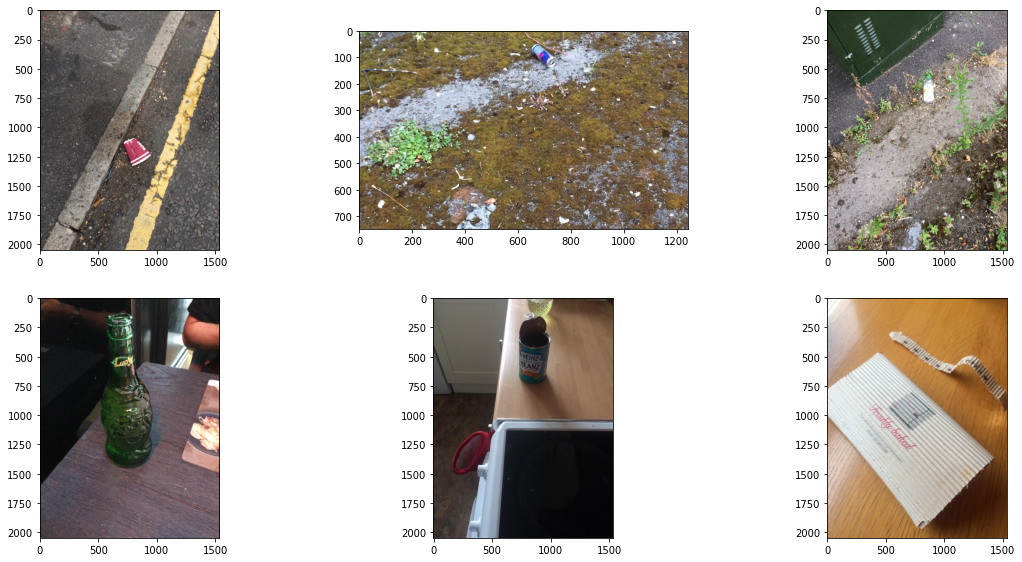

In [ ]:
# plot the images
from matplotlib.image import imread
# define location of dataset
folder = '/content/drive/MyDrive/Colab Notebooks/data/trash_grouped/train_preprocessed/'
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot()

# plot first few images
for i in range(6):
  # define subplot
  plt.subplot(330 + 1 + i)
  filename = 'batch_1_00000' + str(i+3) + '.jpg'
  filepath = folder + 'batch_1_00000' + str(i+3) + '.jpg'
  label = grouped_image_dataframe.loc[grouped_image_dataframe['file_name'] == filename, 'labels']
  print("label:",label)
  ax.set_title('Title with loc at '+ str(label), loc='center')
  ax.set_title(str(label))  
  # load image pixels
  image = imread(filepath)
  # plot raw pixel data
  plt.imshow(image)
  # show the figure

plt.show()

# Modelling

## Build and Train Model


In [ ]:
def build_model_with_transfer_learning(trainable=False, params={}):

    #imports the mobilenet model and discards the last 1000 neuron layer.
   base_model=keras.applications.MobileNetV2(weights='imagenet',
                                             include_top=False,
                                            input_shape=IMAGE_SIZE+(3,))

   base_model.trainable = False                                      

   inputs = keras.Input(shape=IMAGE_SIZE+(3,))
   x = base_model(inputs, training=False)
   x = keras.layers.GlobalAveragePooling2D()(x)
   x=Dense(params['dense_units_1'],activation=params['dense_layer_activation_1'])(x)
   x=Dropout(params['dropout_1'])(x)
   x=Dense(params['dense_units_2'],activation=params['dense_layer_activation_2'])(x)
   x=Dropout(params['dropout_2'])(x)
   x = Flatten()(x)
   x=Dense(params['dense_units_2'],activation=params['dense_layer_activation_2'])(x)
   outputs = keras.layers.Dense(59, activation=params['final_layer_activation'])(x)
   model = keras.Model(inputs, outputs)

   model.summary()
   return model

params = {
    "dense_units_1": 512,
    "dense_layer_activation_1": "relu",
    "dropout_1": 0.3,    
    "dense_units_2": 128,
    "dense_layer_activation_2": "relu",
    "dropout_2": 0.1,
    "final_layer_activation": "sigmoid",
    "learning_rate": 1e-2,
    "n_epochs": 50,    
    "regularizer_rate":0.005
}
run["model/parameters"] = params
model = build_model_with_transfer_learning(params=params)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 512)               655872    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               6566

In [ ]:
from keras import backend
 
# calculate fbeta score for multi-class/label classification
def fbeta(y_true, y_pred, beta=2):
	# clip predictions
	y_pred = backend.clip(y_pred, 0, 1)
	# calculate elements
	tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
	fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
	fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
	# calculate precision
	p = tp / (tp + fp + backend.epsilon())
	# calculate recall
	r = tp / (tp + fn + backend.epsilon())
	# calculate fbeta, averaged across each class
	bb = beta ** 2
	fbeta_score = backend.mean((1 + bb) * (p * r) / (bb * p + r + backend.epsilon()))
	return fbeta_score

In [ ]:
def compile_model(model):
  model.compile(
    optimizer=tf.keras.optimizers.Adam(), 
  loss=keras.losses.BinaryCrossentropy(),
  metrics=[fbeta])
  return model

model = compile_model(model)

In [ ]:
# Add Callbacks

# Model Checkpoint
tl_checkpoint_1 = ModelCheckpoint(filepath = '/content/drive/MyDrive/Colab Notebooks/Models/garbageclassification_model_checkpoint/resnet_best_weights.hdf5', save_best_only = True, verbose = 0)

# Early Stopping Checkpoint
EarlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='val_fbeta', patience=5)

In [ ]:
def train_model(model, num_epochs):
    steps_per_epoch = TRAIN_generator.samples // TRAIN_generator.batch_size
    validation_steps = VAL_generator.samples // VAL_generator.batch_size

    history = model.fit(
      TRAIN_generator,
      epochs=num_epochs, steps_per_epoch=steps_per_epoch,
      validation_data = VAL_generator,
      validation_steps = validation_steps,
      callbacks=[NeptuneCallback(run=run),EarlyStoppingCallback]).history
    
    return model, history

model, history = train_model(model, num_epochs=50)

In [ ]:
# plot diagnostic learning curves
def result_visualization(history):
  # plot loss
  plt.subplot(211)
  plt.title('Cross Entropy Loss')
  plt.plot(history['loss'], color='blue', label='train')
  plt.plot(history['val_loss'], color='orange', label='test')
  # plot accuracy
  plt.subplot(212)
  plt.title('fbeta')
  plt.plot(history['fbeta'], color='blue', label='train')
  plt.plot(history['val_fbeta'], color='orange', label='test')
  return

result_visualization(history)

In [ ]:
def make_prediction(filename):

  class_names = TRAIN_generator.class_indices.items()
  print(class_names)
  
  img = tf.keras.preprocessing.image.load_img(
      filename, target_size=(224, 224)
  )
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.predict(img_array)
  print(predictions)
  score = tf.nn.sigmoid(predictions[0])
  print(score)
  print(list(class_names))
  print( "This image most likely belongs to {} with a {:.2f} percent confidence."
      .format(list(class_names)[np.argmax(score)], 100 * np.max(score)) )
  return

FILE_NAME = '/content/drive/MyDrive/Colab Notebooks/data/trash-test/cigarettebutt (10).jpg'
make_prediction(FILE_NAME)